_Andre Binette_ <abinette@bankofcanada.ca>

_Alexa Evans_ <aevans@bank-banque-canada.ca>

_Dmitri Tchebotarev_ <dtchebotarev@bankofcanada.ca>

# MPR Forecast for CPI

This workbook should "just work". If it does not, or if you find an error, please email the authors above.

# Set up the python environment

### Display plots inline

In [1]:
%matplotlib inline

### Import required modules 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

/home/int/tche/.conda/envs/d/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Display options

In [3]:
pd.set_option('display.max_colwidth',-1)
sns.set(context='paper',rc={'figure.facecolor':'white','axes.facecolor':'gainsboro','grid.color':'white'})

## Import data

Download data from BoC website

In [4]:
web_data = pd.read_csv(\
        'http://www.bankofcanada.ca/valet/observations/group/SAN-2017-21/csv',\
                       skiprows=37,index_col=0)
web_data.index=pd.to_datetime(web_data.index).year
web_data.index.name = 'Year'

### CPI data

In [5]:
cpi_data = web_data.loc[:,['SAN_2017_21_TOTAL_CPI']]
cpi_data.columns = ['Total CPI']
cpi_data = cpi_data.dropna()

### Forecast data - MPR

In [6]:
# For FH4 2003-2005, we used Q3 and Q4 from the MPR and Q1 and Q2 using actual data from StatsCan 
# For 2017 FH1, we have used the underlying data from chart 25 in the April 2016 MPR 
fcast = web_data.iloc[:,0:4]
fcast.columns = ['FH1','FH2','FH3','FH4']
fcast = fcast.dropna(how='all')

## Define helper functions

In [7]:
# make all y axes in a plot have the same min/max. based on
# the most extreme values of all the axes.
def y_axes(plt):
    axmin = min([ax.get_ylim()[0] for ax in plt.gcf().axes])
    axmax = max([ax.get_ylim()[1] for ax in plt.gcf().axes])
    for ax in plt.gcf().axes:
        ax.set_ylim(axmin,axmax)

In [8]:
# take a number and return a string, formatted 0.00
def f1(x):
    return '{:1.2f}'.format(x)

# Data

Create forecast errors by subtracting forecast from total CPI. 

In [9]:
cpi_total = pd.DataFrame(columns = ['FH1', 'FH2','FH3','FH4'], index=cpi_data.index,
                             data = np.tile(cpi_data.values,[1,4])
                            )
forecast_errors = cpi_total.subtract(fcast).dropna(how='all').round(2)

Create RMSPE series.

In [10]:
rmse_forecast = pd.DataFrame()
for col in ['FH1','FH2','FH3','FH4']:
    rmse_forecast.loc['RMSE',col] = np.sqrt(forecast_errors.loc[:,col].pow(2).mean())
rmse_forecast.columns.name='Forecast Horizon'
rmse_forecast.index.name='Sample'

Scale RMSPE by benchmarks.


In [11]:
rmse_naive = rmse_forecast.divide([.71,.74,.55,.21])

In [12]:
rmse_cons = rmse_forecast.divide([0.71,0.69,0.37,0.16])

Create target errors. (Assume forecast is always 2%.)

In [13]:
target_errors = cpi_data.subtract(2)

Create RMSPE from target errors. Values are hard-coded because they are calculated outside of the file.

In [14]:
rmse_target = pd.DataFrame()
for col in ['FH1','FH2','FH3','FH4']:
    rmse_target.loc['RMSE',col] = np.sqrt(target_errors.pow(2).mean()).item()
rmse_target.columns.name='Forecast Horizon'
rmse_target.index.name='Sample'

# Figures

## Figure 1

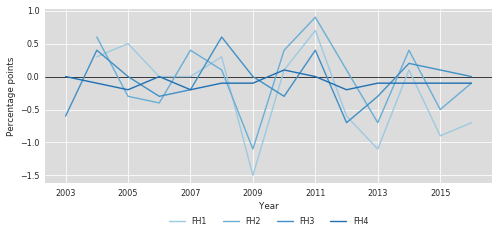

In [15]:
plt.figure(figsize=(8,4))
ax = plt.subplot(111)
pal = sns.color_palette('Blues',n_colors=7)
for i in range(4):
    ax.plot(forecast_errors.iloc[:,i],color=pal[i+2])
ax.axhline(y=0,c='k',zorder=1,linewidth=.75)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=4)
ax.set_xticks([v for i, v in enumerate(forecast_errors.index.append(pd.Index([2017,2018]))) if i % 4 == 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])
ax.set_ylabel("Percentage points")
ax.set_xlabel('Year');
ax.set_xticks([v for i, v in enumerate(forecast_errors.index) if i % 2 == 0]);

## Figure 2

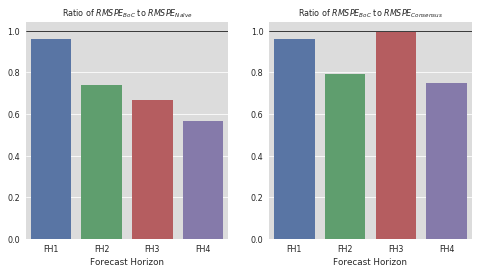

In [16]:
plt.figure(figsize=(8,4))
p = plt.subplot(121)
sns.barplot(data=rmse_naive,ax=p,zorder=2)
p.set_title("Ratio of $RMSPE_{BoC}$ to $RMSPE_{Naïve}$",fontsize='small')
plt.axhline(y=1,zorder=1,color='k',linewidth=.75)

p = plt.subplot(122)
sns.barplot(data=rmse_cons,ax=p,zorder=2)
p.set_title("Ratio of $RMSPE_{BoC}$ to $RMSPE_{Consensus}$",fontsize='small')
plt.axhline(y=1,zorder=1,color='k',linewidth=.75);
y_axes(plt)

# Tables

## Table B1

In [17]:
rmse_forecast.round(2)

Forecast Horizon,FH1,FH2,FH3,FH4
Sample,,,,
RMSE,0.68,0.55,0.37,0.12


# Numbers mentioned in the text

_...blindly using a two per cent forecast..._

In [18]:
rmse_target

Forecast Horizon,FH1,FH2,FH3,FH4
Sample,,,,
RMSE,0.719126,0.719126,0.719126,0.719126


In [19]:
rmse_naive

Forecast Horizon,FH1,FH2,FH3,FH4
Sample,,,,
RMSE,0.961626,0.738265,0.668043,0.569156
